In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.netto79 import Netto79Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

# Model

One-dimensional stochastic dynamical system with state dynamics defined by discrete time map

\begin{equation}
  z_{t+1} = \alpha z_t + \beta \frac{z_t}{1 + z_t^2} + \gamma \cos(\delta t) + \sigma_z u_t
\end{equation}

with $u_t \sim \mathcal{N}(0, 1) ~\forall t$ and $x_0 \sim \mathcal{N}(m, s^2)$.

Observed process defined by

\begin{equation}
  x_{t} = \epsilon x_t^2 + \sigma_x v_t
\end{equation}

with $v_t \sim \mathcal{N}(0, 1)$.

Standard parameter values assumed here are $\alpha = 0.5$, $\beta = 25$, $\gamma = 8$, $\delta = 1.2$, $\epsilon = 0.05$, $m=10$, $s=5$, $\sigma_z^2 = 1$, $\sigma_x^2 = 10$ and $T = 100$ simulated time steps.

Example taken from

> M. L. A. Netto, L. Gimeno, and M. J. Mendes. 
> A new spline algorithm for non-linear filtering of discrete time systems.  
> *Proceedings of the 7th Triennial World Congress*, 1979.

In [2]:
n_steps = 100
seed = 20171027
rng = np.random.RandomState(seed)
model = Netto79Model(rng)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

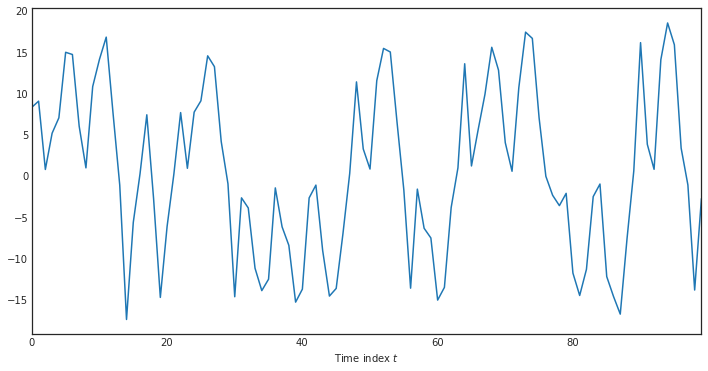

In [4]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference)
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

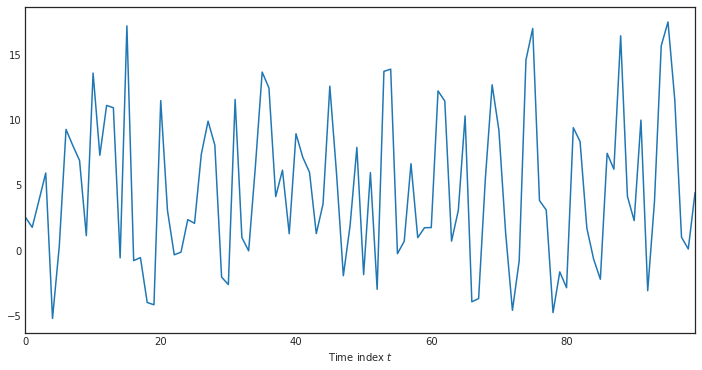

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference)
ax.set_xlabel('Time index $t$')
_ =ax.set_xlim(0, n_steps - 1)

## Infer state from observations

### Ensemble Kalman filter (perturbed observations)

In [6]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [7]:
%%time
results_enkf = enkf.filter(x_reference, 500)

CPU times: user 96 ms, sys: 8 ms, total: 104 ms
Wall time: 63.8 ms


### Bootstrap particle filter

In [8]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [9]:
%%time
results_bspf = bspf.filter(x_reference, 500)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 103 ms


### Ensemble transform particle filter

In [10]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [11]:
%%time
results_etpf = etpf.filter(x_reference, 500)

CPU times: user 17.3 s, sys: 660 ms, total: 18 s
Wall time: 9.29 s


### Visualise estimated means of filtering distribution

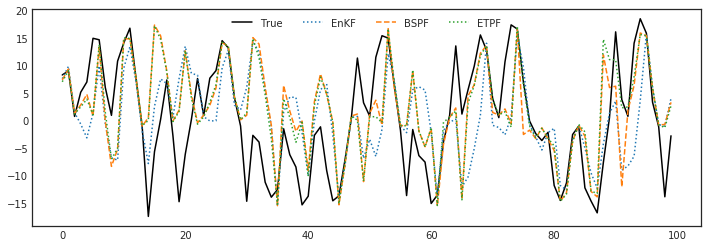

In [13]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[:, 0], 'k', label='True')
ax.plot(results_enkf['z_mean_seq'][:, 0], ':', label='EnKF')
ax.plot(results_bspf['z_mean_seq'][:, 0], '--', label='BSPF')
ax.plot(results_etpf['z_mean_seq'][:, 0], ':', label='ETPF')
ax.legend(ncol=4)